In [ ]:
!pip install paddlex -i https://mirror.baidu.com/pypi/simple
!pip install imgaug -i https://mirror.baidu.com/pypi/simple
!pip install paddlelite -i https://mirror.baidu.com/pypi/simple

In [ ]:
!unzip VOCData.zip

In [ ]:
from random import shuffle
from tqdm import tqdm
import imgaug.augmenters as iaa
import cv2
import os

base = 'VOCData'

imgs = [v for v in os.listdir(base) if v.endswith('.jpg')]

shuffle(imgs)

with open('train.txt', 'w') as f:
  for im in tqdm(imgs):
    xml = im[:-4]+'.xml'
    info = im + ' ' + xml
    if not cv2.imread(os.path.join(base, im)) is None:
      f.write(info+'\n')

with open('eval.txt', 'w') as f:
  for im in tqdm(imgs):
    xml = im[:-4]+'.xml'
    info = im + ' ' + xml
    if not cv2.imread(os.path.join(base, im)) is None:
      f.write(info+'\n')

labels = ['black', 'white']
with open('labels.txt', 'w') as f:
  for lbl in labels:
    f.write(lbl+'\n')

100%|██████████| 129/129 [00:00<00:00, 263.15it/s]


In [ ]:
from paddlex.det import transforms
import imgaug.augmenters as iaa

train_transforms = transforms.Compose([
    transforms.RandomCrop(),
    # iaa.GaussianBlur(sigma=(0.0, 3.0)),
    iaa.MultiplyAndAddToBrightness(mul=(0.5, 1.5), add=(-30, 30)),
    iaa.Cutout(fill_mode="constant", cval=(0, 255), fill_per_channel=0.5),
    transforms.RandomHorizontalFlip(),
    iaa.SaltAndPepper(0.1),
    # transforms.RandomDistort(),
    transforms.RandomExpand(),
    transforms.Resize(target_size=608, interp='RANDOM'),
    # transforms.RandomCrop(608),
    transforms.Normalize(),
])

eval_transforms = transforms.Compose([
    transforms.Resize(target_size=608, interp='CUBIC'),
    transforms.Normalize(),
])

In [ ]:
import os
import cv2
from tqdm import tqdm
import xml.etree.ElementTree as ET

base = 'VOCData'


xmls = [v for v in os.listdir(base) if v.endswith('.xml')]

for x in xmls:
    updateTree = ET.parse(os.path.join(base, x))   # 读取待修改文件
    root = updateTree.getroot()

    W = root.find("size").find("width")
    H = root.find("size").find("height")
    try:
        print(x, end='\t')
        print(float(W.text), end='\t')
        print(float(H.text), end='\r')
    except ValueError as e:
        print(x)
        print(e)
        im = cv2.imread(os.path.join(base, x[:-4]+'.jpg'))
        h, w = im.shape[:2]
        W.text = str(w)
        H.text = str(h)
        updateTree.write(os.path.join(base, x))

In [ ]:
import paddlex as pdx

base = 'VOCData'

train_dataset = pdx.datasets.VOCDetection(
    data_dir=base,
    file_list='train.txt',
    label_list='labels.txt',
    transforms=train_transforms,
    shuffle=True)
    
eval_dataset = pdx.datasets.VOCDetection(
    data_dir=base,
    file_list='eval.txt',
    label_list='labels.txt',
    transforms=eval_transforms)

2020-11-20 19:29:45 [INFO]	Starting to read file list from dataset...
2020-11-20 19:29:46 [INFO]	129 samples in file train.txt
creating index...
index created!
2020-11-20 19:29:46 [INFO]	Starting to read file list from dataset...
2020-11-20 19:29:46 [INFO]	129 samples in file eval.txt
creating index...
index created!


In [10]:
num_classes = len(train_dataset.labels)
print('class num:', num_classes)
model = pdx.det.YOLOv3(num_classes=num_classes, backbone='MobileNetV1')
model.train(
    num_epochs=48,
    train_dataset=train_dataset,
    train_batch_size=4,
    eval_dataset=eval_dataset,
    learning_rate=0.00025,
    lr_decay_epochs=[60, 160],
    save_interval_epochs=16,
    log_interval_steps=100,
    save_dir='./YOLOv3',
    pretrain_weights='YOLOv3/best_model',
    use_vdl=True)

In [11]:
model = pdx.load_model('YOLOv3/best_model')
model.evaluate(eval_dataset, batch_size=1, epoch_id=None, metric=None, return_details=False)

2020-11-20 19:33:13 [INFO]	Model[YOLOv3] loaded.
2020-11-20 19:33:13 [INFO]	Start to evaluating(total_samples=129, total_steps=129)...


100%|██████████| 129/129 [00:09<00:00, 13.29it/s]


OrderedDict([('bbox_map', 100.0)])

2020-11-20 19:34:48 [INFO]	Model[YOLOv3] loaded.
infer time:0.069679s
detected num: 13


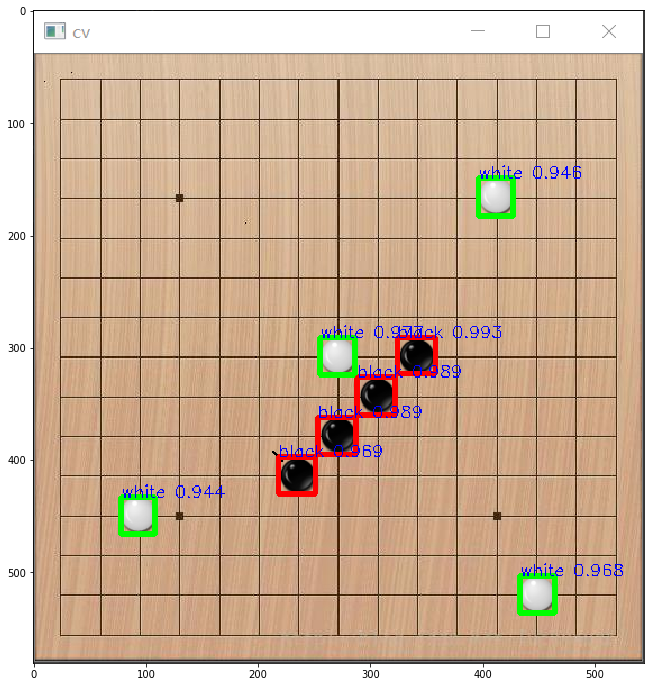

infer time:0.035611s
detected num: 51


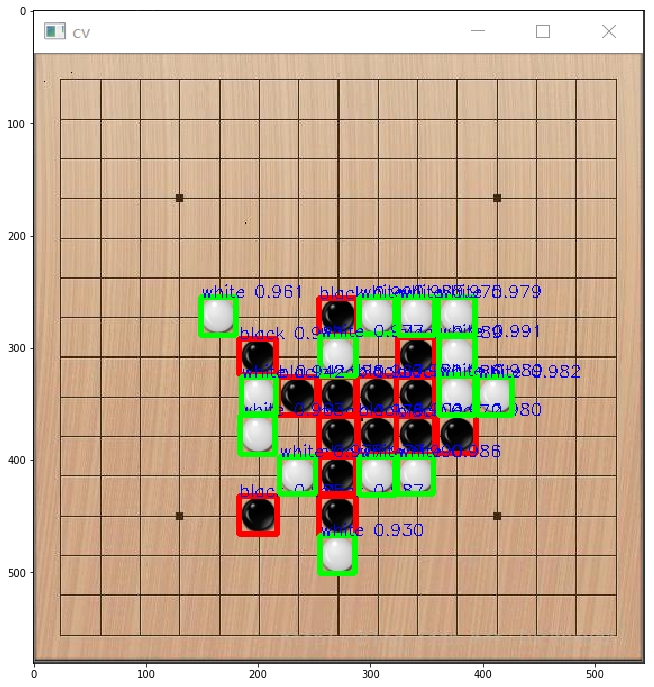

In [14]:
import os
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
import paddlex as pdx
%matplotlib inline

model = pdx.load_model('YOLOv3/best_model')

base = 'images'
for im in os.listdir(base):
    if not im.endswith('.png'):
        continue
    image_name = os.path.join(base, im)
    start = time.time()
    result = model.predict(image_name)
    print('infer time:{:.6f}s'.format(time.time()-start))
    print('detected num:', len(result))

    im = cv2.imread(image_name)
    font = cv2.FONT_HERSHEY_SIMPLEX
    threshold = 0.2

    for value in result:
        xmin, ymin, w, h = np.array(value['bbox']).astype(np.int)
        cls = value['category']
        score = value['score']
        if score < threshold:
            continue
        if cls == 'white':
            color = (0, 255, 0)
        else:
            color = (0, 0, 255)
        cv2.rectangle(im, (xmin, ymin), (xmin+w, ymin+h), color, 3)
        cv2.putText(im, '{:s} {:.3f}'.format(cls, score),
                        (xmin, ymin), font, 0.5, (255, 0, 0), thickness=1)

    plt.figure(figsize=(15,12))
    plt.imshow(im[:, :, [2,1,0]])
    plt.show()